<a href="https://colab.research.google.com/github/PabloAS79/Electoral-Analytics/blob/main/Electoral_Modelo_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate dummy data


In [10]:
import pandas as pd
import numpy as np

# Initial data
data = {
    'ElectionYear': [2020, 2020, 2020, 2016, 2016],
    'District': ['District_1', 'District_2', 'District_3', 'District_1', 'District_2'],
    'MORENA': [500, 600, 450, 480, 580],
    'PRIANPRD': [300, 400, 350, 320, 420],
    'OTROS': [200, 300, 250, 220, 300],
    'Votos_Totales': [1000, 1300, 1050, 1020, 1300],
    'Participación': [.62, .45, .49, .34, .65],
    'Educación': [.26, .18, .50, .49, .15],
    'Violencia': [.36, .78, .48, .27, .59]
}

df = pd.DataFrame(data)

# Add 'TIPO' column with random labels 'Presidencial', 'Estatal'
np.random.seed(42)
df['TIPO'] = np.random.choice(['Presidencial', 'Estatal'], size=len(df))

# Add 'Weight' column where weights sum to 1
df['Weight'] = np.random.random(len(df))
df['Weight'] = df['Weight'] / df['Weight'].sum()

# Generate 2000 more lines with noise
additional_data = pd.DataFrame({
    'ElectionYear': np.random.choice([2020, 2016], size=2000),
    'District': np.random.choice(['District_1', 'District_2', 'District_3'], size=2000),
    'MORENA': np.random.normal(loc=500, scale=50, size=2000),
    'PRIANPRD': np.random.normal(loc=400, scale=50, size=2000),
    'OTROS': np.random.normal(loc=300, scale=50, size=2000),
    'Votos_Totales': np.nan,  # Placeholder, will be recalculated
    'Participación': np.random.normal(loc=0.5, scale=0.1, size=2000),
    'Educación': np.random.normal(loc=0.3, scale=0.1, size=2000),
    'Violencia': np.random.normal(loc=0.5, scale=0.1, size=2000),
    'TIPO': np.random.choice(['Presidencial', 'Estatal'], size=2000),
    'Weight': np.random.random(2000)
})

# Concatenate the additional data to the original DataFrame
df = pd.concat([df, additional_data], ignore_index=True)

# Normalize the 'Weight' column so that weights sum to 1
df['Weight'] = df['Weight'] / df['Weight'].sum()

# Replace any negative values with 0
df[['MORENA', 'PRIANPRD', 'OTROS', 'Participación', 'Educación', 'Violencia']] = df[['MORENA', 'PRIANPRD', 'OTROS', 'Participación', 'Educación', 'Violencia']].clip(lower=0)

# Convert party votes to percentages so they add up to 1 by row
party_cols = ['MORENA', 'PRIANPRD', 'OTROS']
df[party_cols] = df[party_cols].div(df[party_cols].sum(axis=1), axis=0)

# Recalculate 'Votos_Totales' to ensure consistency
df['Votos_Totales'] = df[party_cols].sum(axis=1)

# Reorder columns
df = df[['TIPO', 'ElectionYear', 'District', 'Weight', 'MORENA', 'PRIANPRD', 'OTROS', 'Votos_Totales', 'Participación', 'Educación', 'Violencia']]




## Multiple Outup Model (These models calculate the next period values)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 2005, number of used features: 5
[LightGBM] [Info] Start training from score 0.417830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 2005, number of used features: 5
[LightGBM] [Info] Start training from score 0.332209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 2005,

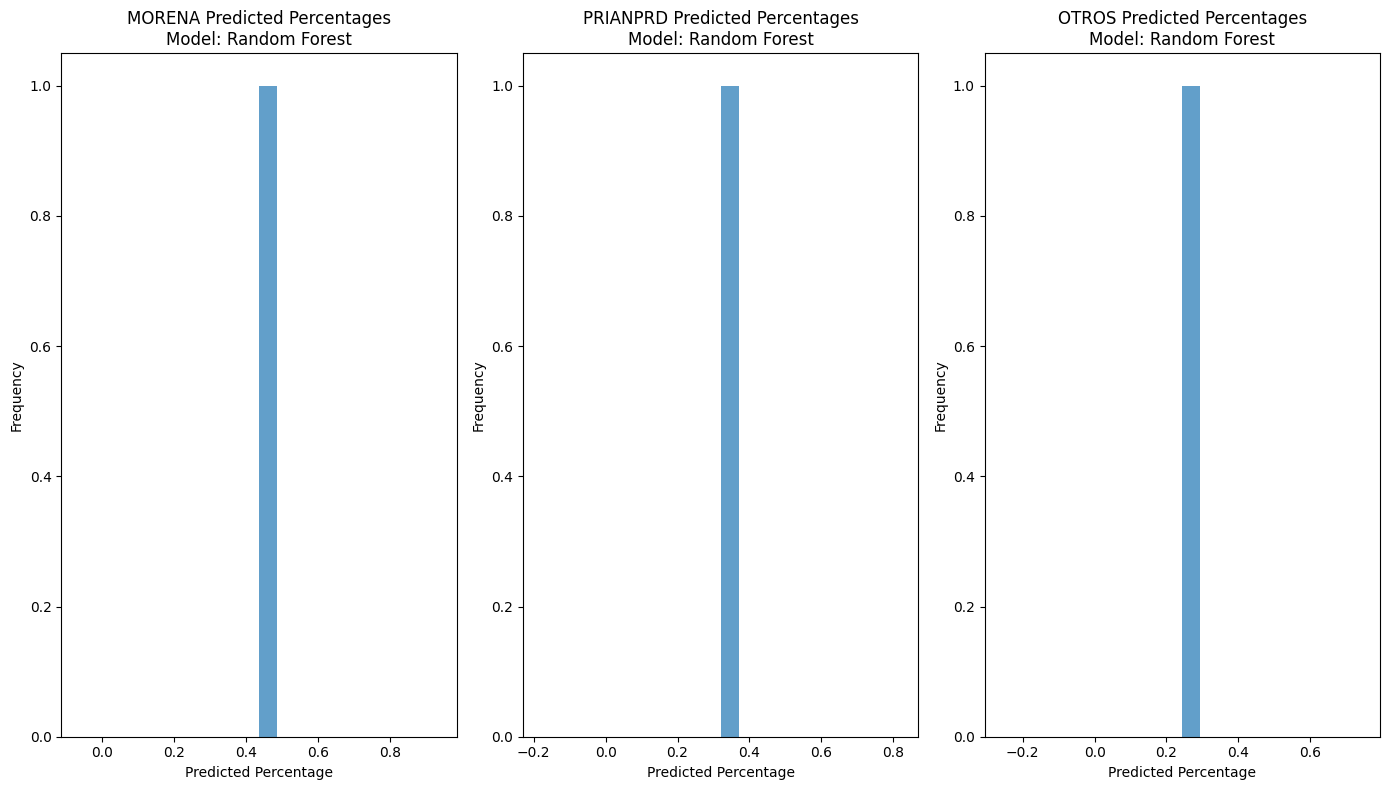

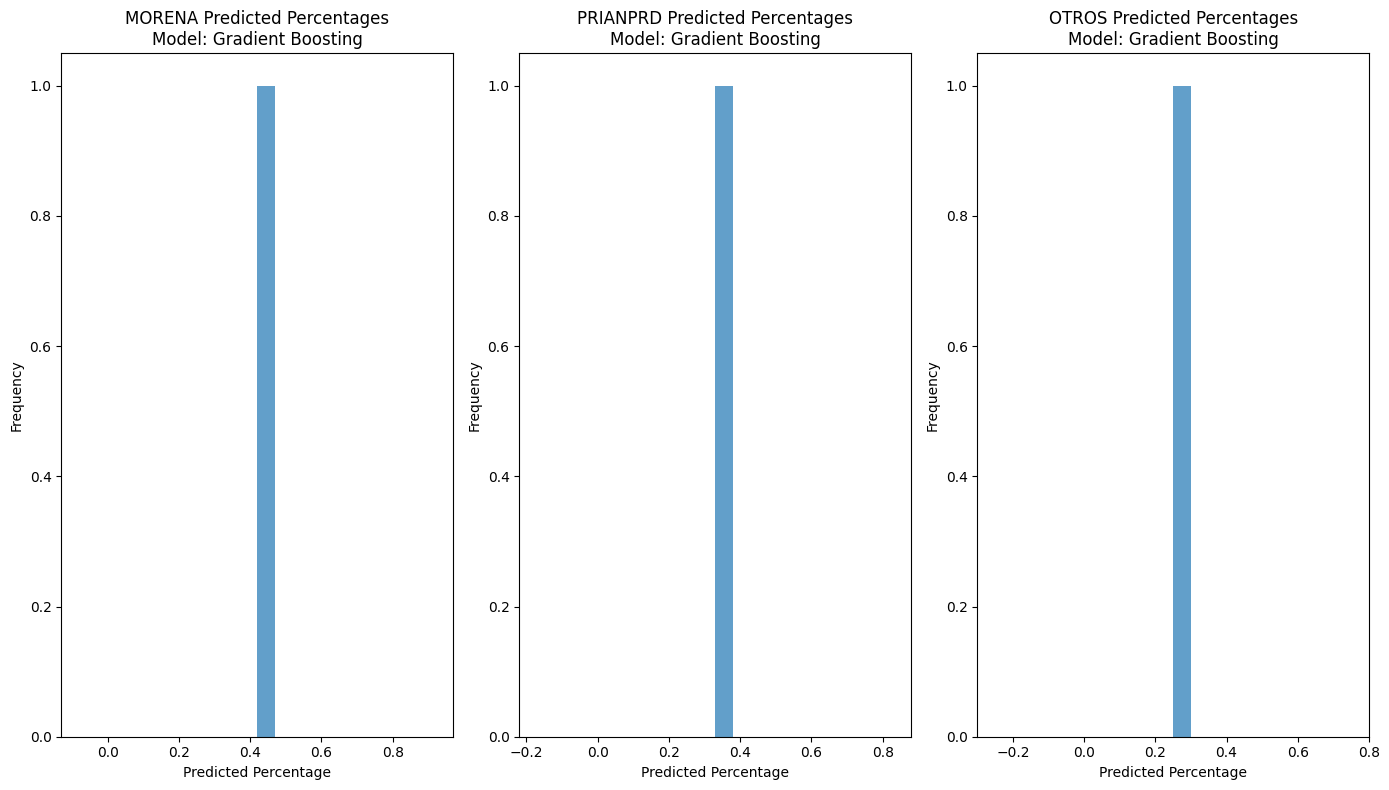

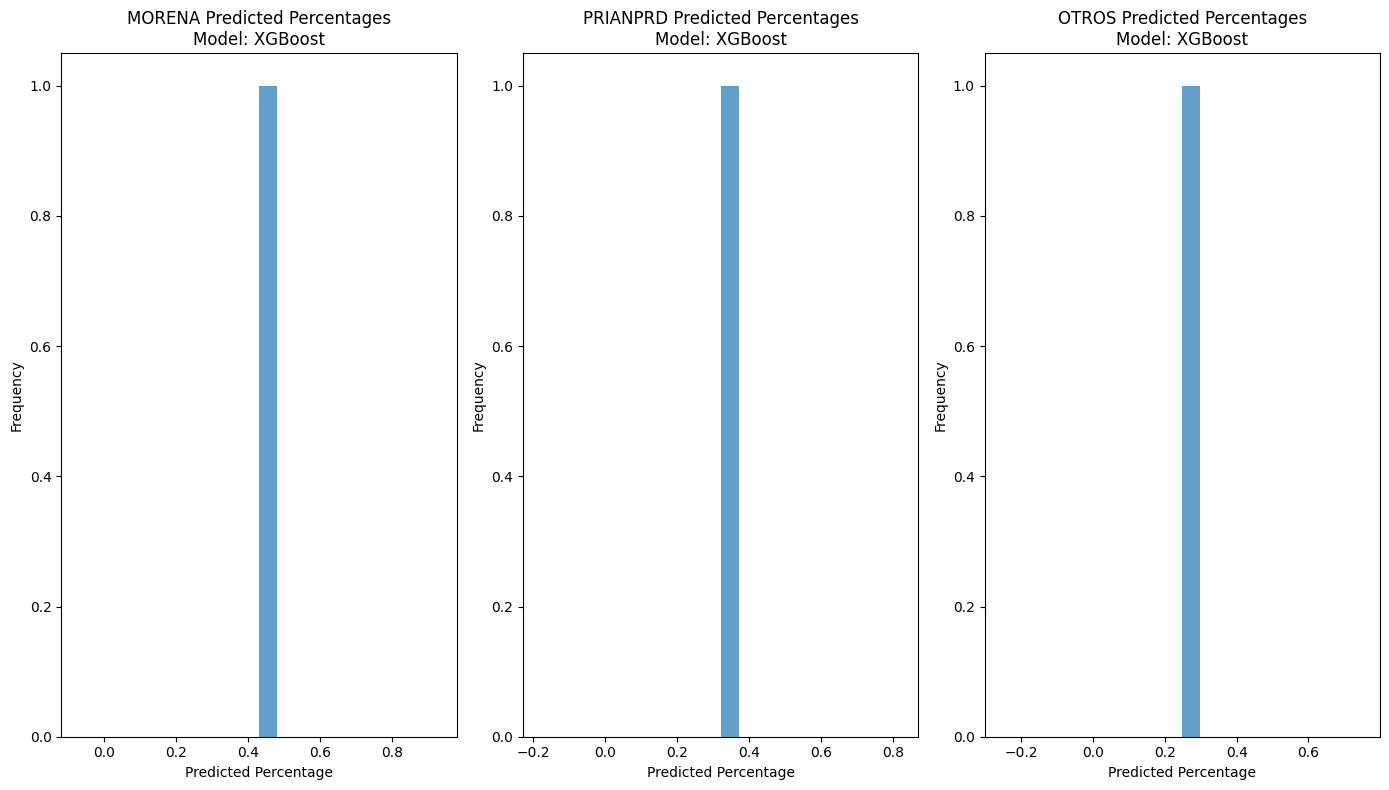

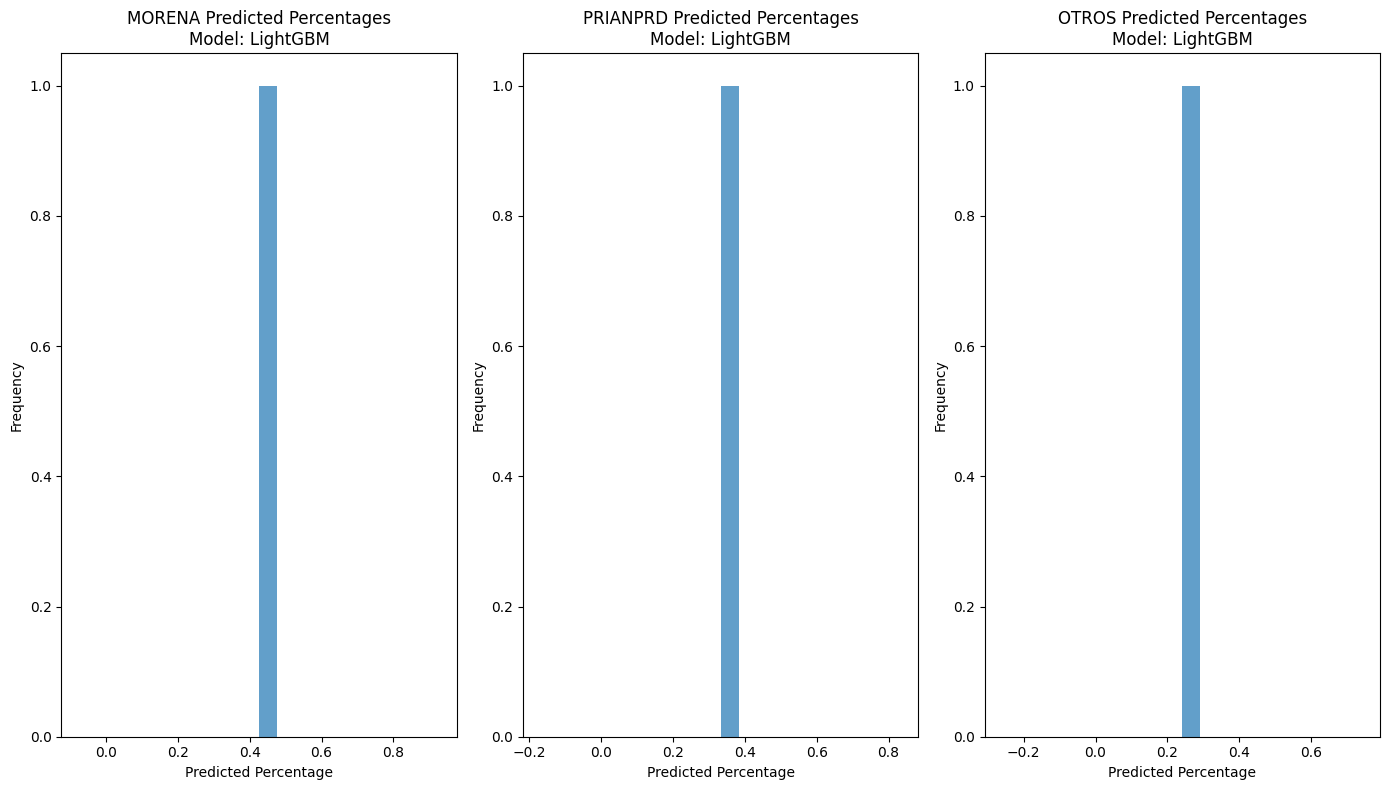

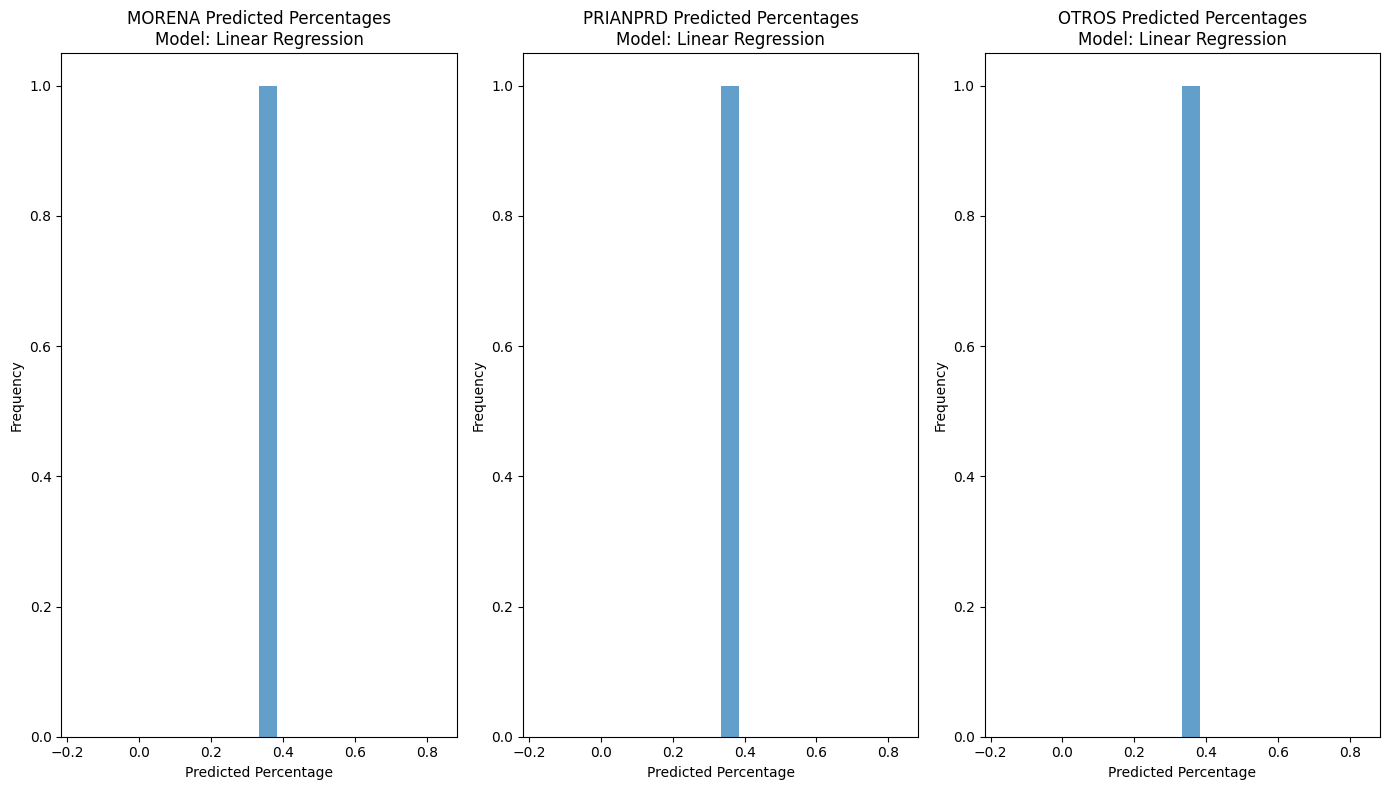

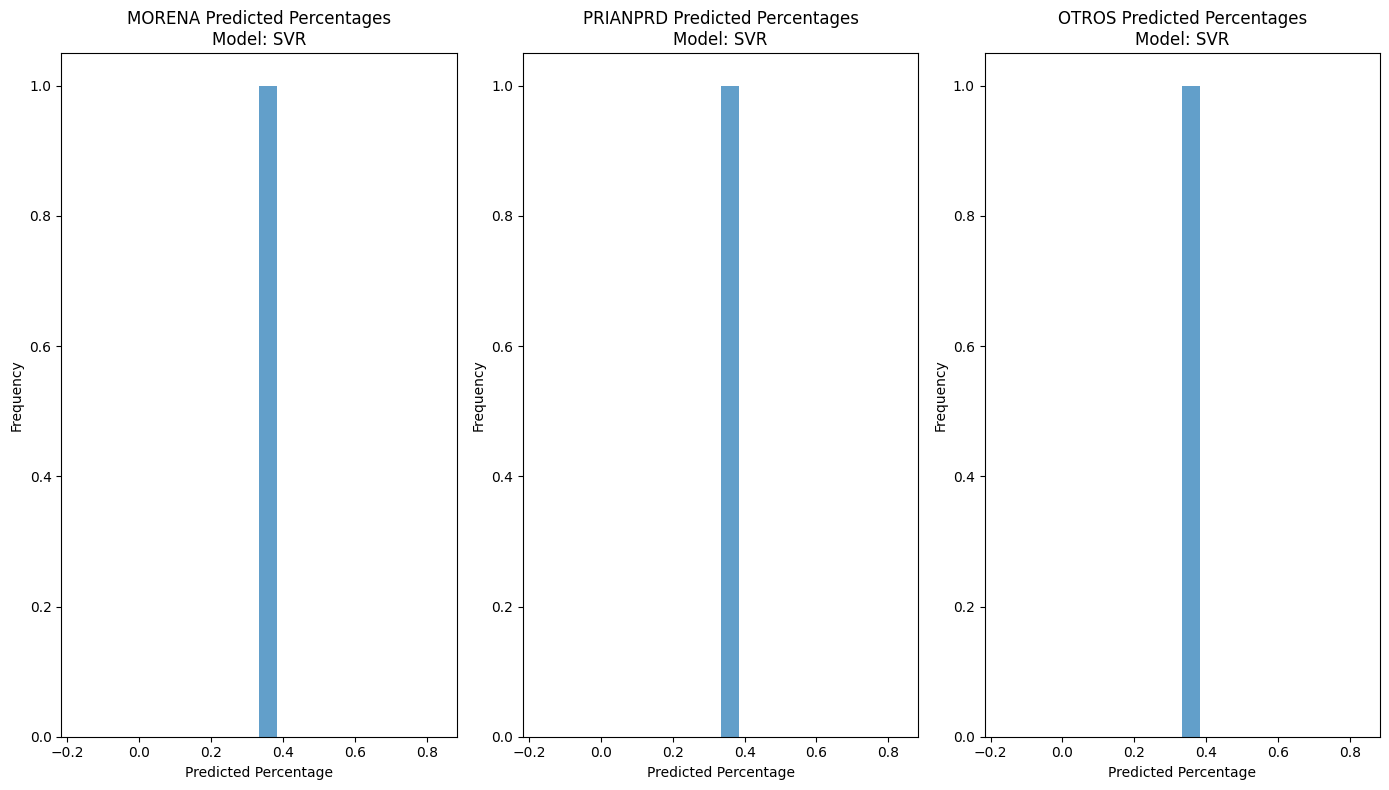

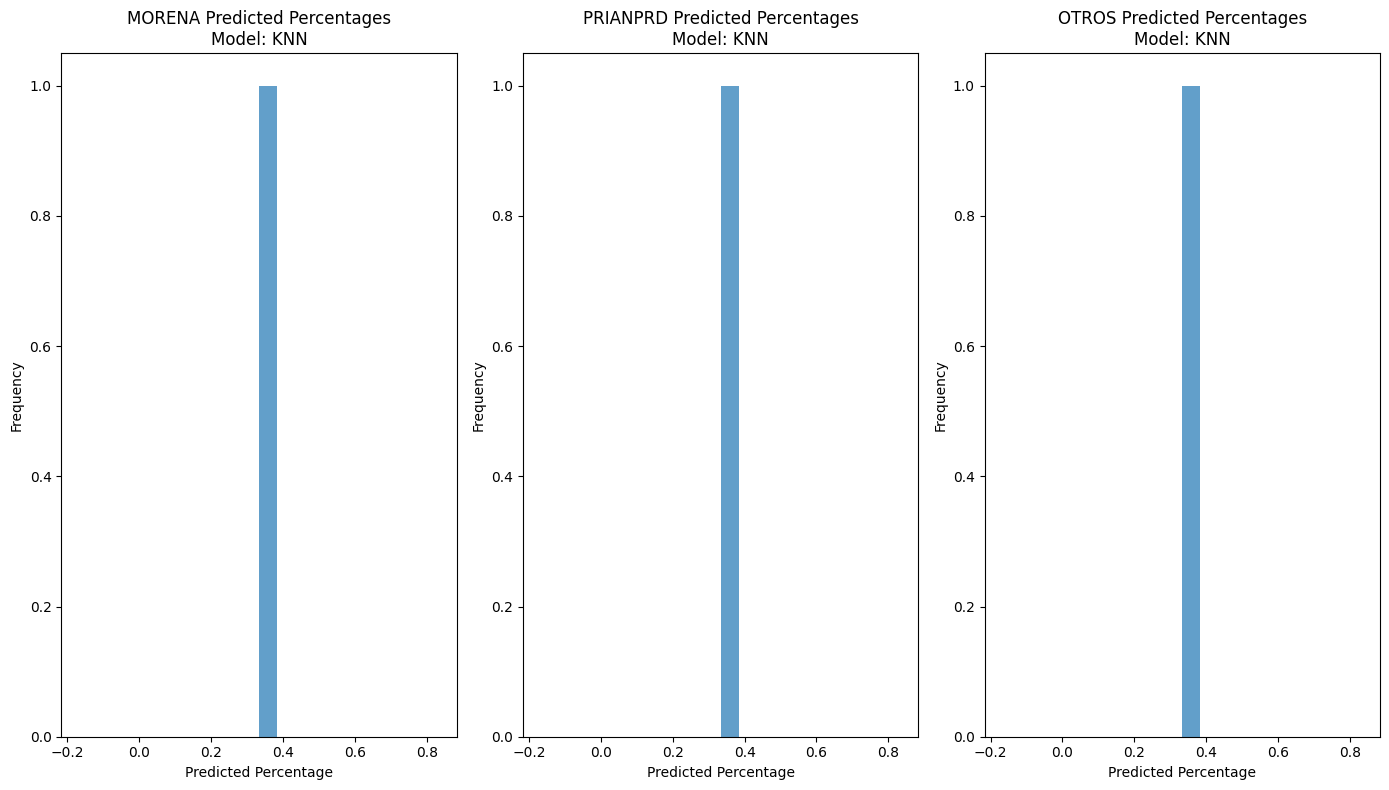

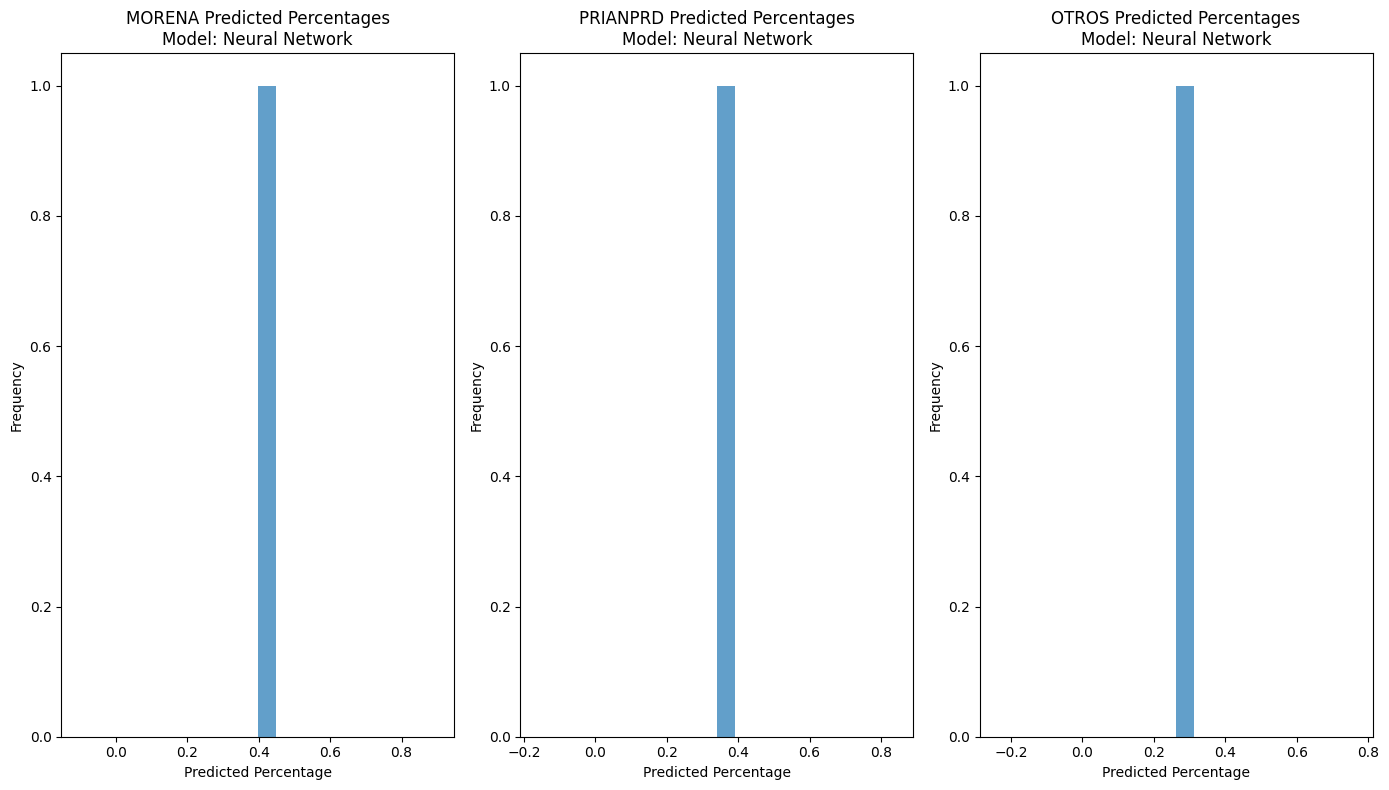

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt



# Prepare features and labels
X = df.drop(columns=['TIPO', 'ElectionYear', 'Weight', 'MORENA', 'PRIANPRD', 'OTROS', 'Votos_Totales'])
y = df[['MORENA', 'PRIANPRD', 'OTROS']]

# Convert categorical 'District' column to numeric using one-hot encoding
X = pd.get_dummies(X, columns=['District'], drop_first=True)

# Define function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize dictionaries to store metrics and predictions
mse_scores = {}
mae_scores = {}
mape_scores = {}
trained_models = {}

# Multi-output models
multi_output_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Single-output models
single_output_models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=3)
}

# Train and evaluate multi-output models using MultiOutputRegressor on the entire dataset
for name, model in multi_output_models.items():
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X, y)
    preds = multi_model.predict(X)
    mse_scores[name] = mean_squared_error(y, preds)
    mae_scores[name] = mean_absolute_error(y, preds)
    mape_scores[name] = mean_absolute_percentage_error(y, preds)
    trained_models[name] = multi_model

# Train and evaluate single-output models on the entire dataset
for name, model in single_output_models.items():
    model_mse = []
    model_mae = []
    model_mape = []
    preds_list = []
    trained_model_list = []

    for i in range(y.shape[1]):
        model.fit(X, y.iloc[:, i])
        preds = model.predict(X)
        preds_list.append(preds)
        model_mse.append(mean_squared_error(y.iloc[:, i], preds))
        model_mae.append(mean_absolute_error(y.iloc[:, i], preds))
        model_mape.append(mean_absolute_percentage_error(y.iloc[:, i], preds))
        trained_model_list.append(model)

    mse_scores[name] = np.mean(model_mse)
    mae_scores[name] = np.mean(model_mae)
    mape_scores[name] = np.mean(model_mape)
    trained_models[name] = trained_model_list

# Neural Network Model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(3))  # Output layer for three parties

nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_scaled, y, epochs=100, batch_size=10, verbose=1)

nn_preds = nn_model.predict(X_scaled)
mse_scores['Neural Network'] = mean_squared_error(y, nn_preds)
mae_scores['Neural Network'] = mean_absolute_error(y, nn_preds)
mape_scores['Neural Network'] = mean_absolute_percentage_error(y, nn_preds)
trained_models['Neural Network'] = nn_model

# Predict for the next period based on historical data
# Create a dummy new period data point for prediction
X_new_period = X.mean().to_frame().T  # Use mean values of historical data for prediction

# Ensure the new period data has the same columns as the training set
X_new_period = X_new_period.reindex(columns=X.columns, fill_value=0)

# Scale the new period data for the neural network
X_new_period_scaled = scaler.transform(X_new_period)

# Predictions for the new period
new_period_predictions = {}

for name, model in multi_output_models.items():
    multi_model = trained_models[name]
    preds = multi_model.predict(X_new_period)
    preds /= preds.sum()  # Ensure the predictions sum to 1
    new_period_predictions[name] = preds

for name, models in single_output_models.items():
    preds_list = []
    for i, model in enumerate(trained_models[name]):
        preds = model.predict(X_new_period)
        preds_list.append(preds)
    preds = np.column_stack(preds_list)
    preds /= preds.sum(axis=1, keepdims=True)  # Ensure the predictions sum to 1
    new_period_predictions[name] = preds

nn_new_period_predictions = trained_models['Neural Network'].predict(X_new_period_scaled)
nn_new_period_predictions /= nn_new_period_predictions.sum()  # Ensure the predictions sum to 1
new_period_predictions['Neural Network'] = nn_new_period_predictions

# Print MSE, MAE, and MAPE scores for all models
print("Mean Squared Error (MSE) Scores:")
for name, score in mse_scores.items():
    print(f"{name}: {score}")

print("\nMean Absolute Error (MAE) Scores:")
for name, score in mae_scores.items():
    print(f"{name}: {score}")

print("\nMean Absolute Percentage Error (MAPE) Scores:")
for name, score in mape_scores.items():
    print(f"{name}: {score}")

# Print new period predictions
for name, preds in new_period_predictions.items():
    print(f"\n{name} predictions for the next period:")
    print(preds)

# Plot detailed histograms for each party
def plot_histograms(predictions, party_names):
    for model_name, preds in predictions.items():
        plt.figure(figsize=(14, 8))
        for i, party in enumerate(party_names):
            plt.subplot(1, len(party_names), i + 1)
            plt.hist(preds[:, i], bins=20, alpha=0.7, label=party)
            plt.title(f'{party} Predicted Percentages\nModel: {model_name}')
            plt.xlabel('Predicted Percentage')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# Party names
party_names = ['MORENA', 'PRIANPRD', 'OTROS']

# Plot histograms
plot_histograms(new_period_predictions, party_names)
